# CNN 실습

이 실습에서는 CIFAR10 데이터셋을 사용하여 간단한 CNN 모델을 구현하고 고도화하는 과정을 실습합니다.

## CIFAR10 데이터셋

CIFAR10은 10개의 다른 클래스로 구성된 60,000개의 32x32 컬러 이미지를 포함하는 데이터셋입니다. 이 데이터셋은 기계 학습 연구와 컴퓨터 비전 연구에 널리 사용됩니다.

### 클래스

CIFAR10 데이터셋에는 다음과 같은 10개의 클래스가 있습니다:

1. 비행기
2. 자동차
3. 새
4. 고양이
5. 사슴
6. 개
7. 개구리
8. 말
9. 배
10. 트럭

각 클래스는 6,000개의 이미지로 구성되어 있습니다.

### 데이터 분할

CIFAR10 데이터셋은 50,000개의 훈련 이미지와 10,000개의 테스트 이미지로 분할되어 있습니다. 이 분할은 모델의 성능을 공정하게 평가하는 데 사용됩니다.

### 사용 사례

CIFAR10은 다양한 이미지 분류 작업에 사용됩니다. 이 데이터셋은 간단한 CNN부터 복잡한 딥 러닝 아키텍처까지 다양한 모델을 훈련시키는 데 사용할 수 있습니다.

In [3]:
import torch
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
drive.mount('/content/drive')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
True


In [4]:
# 데이터 로드 및 전처리
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# 원본 데이터셋 로드
dataset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/Deep_Learning/20250421/', train=True,
                                        download=True, transform=transform)

# 학습 및 검증 데이터셋으로 분할
train_size = int(0.8 * len(dataset))  # 학습 데이터셋의 크기를 전체의 80%로 설정
val_size = len(dataset) - train_size  # 검증 데이터셋의 크기를 나머지 20%로 설정
trainset, valset = torch.utils.data.random_split(dataset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=4)
valloader = torch.utils.data.DataLoader(valset, batch_size=64,
                                        shuffle=False, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/Deep_Learning/20250421/', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=4)

100%|██████████| 170M/170M [00:05<00:00, 29.9MB/s]


In [5]:
# CIFAR10 클래스 정의
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


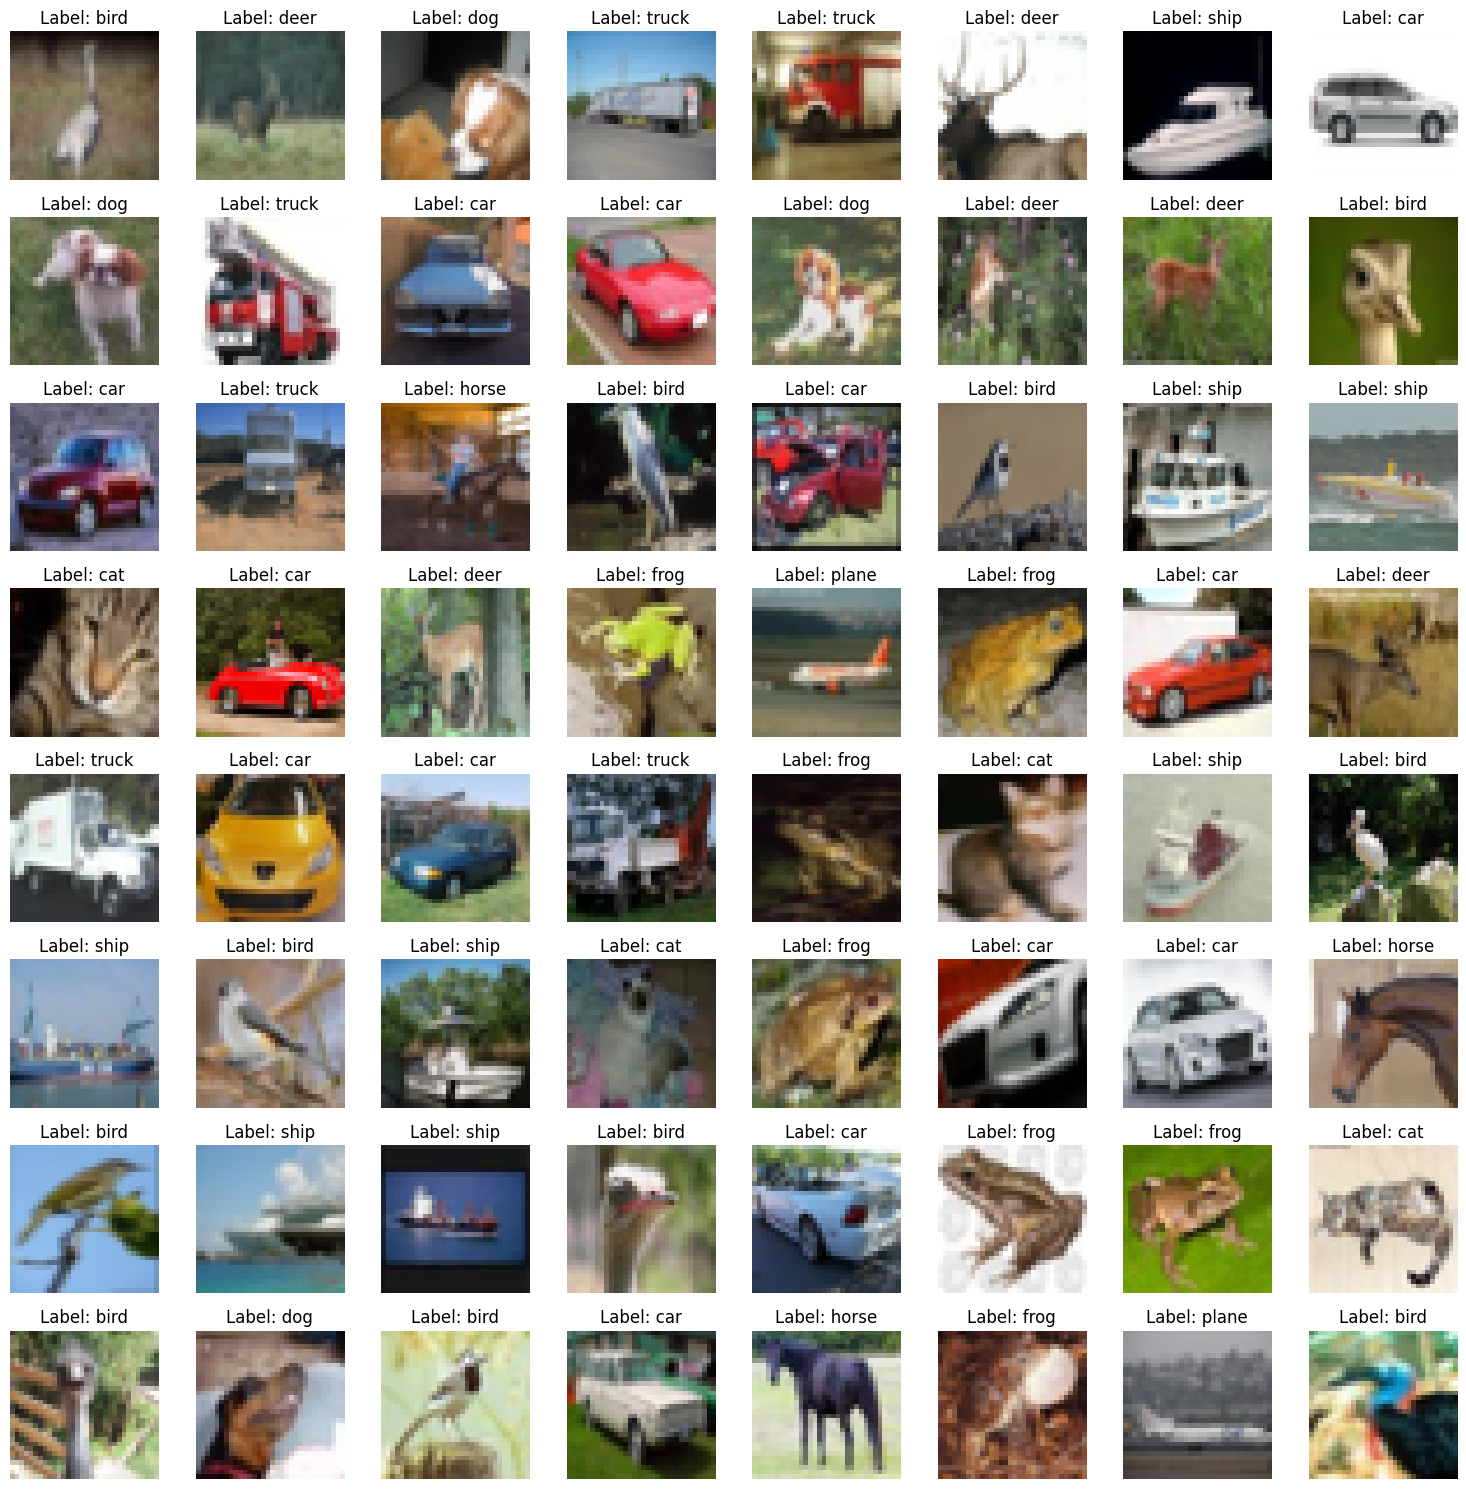

In [6]:
# 이미지를 보여주기 위한 함수
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# 데이터 로더에서 한 배치의 데이터를 가져옵니다.
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 8x8 그리드로 이미지를 출력하고, 각 이미지 아래에 레이블을 출력합니다.
fig, axs = plt.subplots(8, 8, figsize=(15, 15))
for i in range(64):
    ax = axs[i // 8, i % 8]
    ax.imshow(np.transpose(images[i] / 2 + 0.5, (1, 2, 0)))  # unnormalize and transpose
    ax.axis('off')
    ax.set_title('Label: %s' % classes[labels[i]])
plt.tight_layout()
plt.show()

# DNN 모델 정의 및 훈련

이 코드는 CIFAR10 데이터셋에 대해 DNN(Deep Neural Network) 모델을 정의하고 훈련하는 과정을 보여줍니다.

## 모델 정의

`DNN` 클래스는 PyTorch의 `nn.Module`을 상속받아 DNN 모델을 정의합니다. 이 모델은 세 개의 완전 연결 층(`fc1`, `fc2`, `fc3`)으로 구성되어 있습니다.

## 손실 함수와 옵티마이저

손실 함수로는 교차 엔트로피 손실(`nn.CrossEntropyLoss`)을 사용하고, 옵티마이저로는 Adam 최적화 알고리즘(`optim.Adam`)을 사용합니다.

## 모델 훈련

모델 훈련은 데이터셋을 여러 번 반복하면서 진행됩니다. 각 반복에서는 다음과 같은 과정이 이루어집니다:

1. 입력 데이터와 레이블을 받습니다.
2. 옵티마이저의 변화도를 0으로 초기화합니다.
3. 모델에 입력을 전달하여 출력을 얻습니다.
4. 출력과 레이블을 손실 함수에 전달하여 손실을 계산합니다.
5. 손실에 대한 역전파를 수행합니다.
6. 옵티마이저를 사용하여 모델의 파라미터를 업데이트합니다.

매 200 미니배치마다 현재까지의 평균 손실을 출력합니다. 이 과정을 통해 모델이 어떻게 학습되는지를 관찰할 수 있습니다.

In [7]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 512)  # CIFAR10의 이미지 크기는 32x32, 채널은 3입니다.
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)  # CIFAR10의 클래스 수는 10입니다.

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)  # 이미지를 1차원으로 펼칩니다.
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 모델 생성
dnn = DNN().to(device)
dnn.train()

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(dnn.parameters(), lr=0.001)

## 모델 훈련
for epoch in range(10):  # 데이터셋을 여러번 반복
    dnn.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 입력을 받은 후
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # 변화도(Gradient) 매개변수를 0으로 만든 후
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화
        outputs = dnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계 출력
        running_loss += loss.item()
        if i % 200 == 199:    # 200 미니배치마다 출력
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

    # 검증
    dnn.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(valloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = dnn(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= i+1
    print(f'Validation loss: {val_loss:.3f}')

print('Finished Training')

[1,   200] loss: 1.799
[1,   400] loss: 1.640
[1,   600] loss: 1.567
Validation loss: 1.556
[2,   200] loss: 1.463
[2,   400] loss: 1.449
[2,   600] loss: 1.434
Validation loss: 1.461
[3,   200] loss: 1.316
[3,   400] loss: 1.354
[3,   600] loss: 1.332
Validation loss: 1.426
[4,   200] loss: 1.227
[4,   400] loss: 1.249
[4,   600] loss: 1.247
Validation loss: 1.422
[5,   200] loss: 1.128
[5,   400] loss: 1.158
[5,   600] loss: 1.181
Validation loss: 1.429
[6,   200] loss: 1.043
[6,   400] loss: 1.080
[6,   600] loss: 1.077
Validation loss: 1.428
[7,   200] loss: 0.952
[7,   400] loss: 1.002
[7,   600] loss: 1.008
Validation loss: 1.450
[8,   200] loss: 0.872
[8,   400] loss: 0.904
[8,   600] loss: 0.936
Validation loss: 1.532
[9,   200] loss: 0.800
[9,   400] loss: 0.829
[9,   600] loss: 0.871
Validation loss: 1.580
[10,   200] loss: 0.730
[10,   400] loss: 0.756
[10,   600] loss: 0.794
Validation loss: 1.649
Finished Training


# 모델 정확도 계산 함수

`calculate_accuracy` 함수는 테스트 데이터셋에 대한 모델의 정확도를 계산하고 출력합니다.

## 함수 인자

- `testloader`: 테스트 데이터셋을 로드하는 DataLoader입니다.
- `model`: 테스트할 모델입니다.

## 함수 동작

1. `correct`와 `total`을 0으로 초기화합니다. `correct`는 올바르게 분류된 이미지의 수를 저장하고, `total`은 테스트 데이터셋의 전체 이미지 수를 저장합니다.
2. `torch.no_grad()`를 사용하여 기울기 계산을 비활성화합니다. 이는 테스트 중에는 기울기를 계산할 필요가 없기 때문입니다.
3. `testloader`로부터 데이터를 받아옵니다.
4. 모델에 이미지를 전달하여 출력을 얻습니다.
5. `torch.max()`를 사용하여 가장 높은 값을 가진 클래스를 예측값으로 선택합니다.
6. 예측값과 실제 레이블을 비교하여 올바르게 분류된 이미지의 수를 계산합니다.
7. 전체 이미지 수 대비 올바르게 분류된 이미지의 비율을 계산하여 정확도를 계산하고 출력합니다.

In [8]:
def calculate_accuracy(testloader, model):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test images: %.2f %%' % (
        100 * correct / total))

In [9]:
calculate_accuracy(testloader, dnn)

Accuracy of the network on the test images: 51.65 %


# CNN 모델 정의 및 훈련

이 코드는 CIFAR10 데이터셋에 대해 CNN(Convolutional Neural Network) 모델을 정의하고 훈련하는 과정을 보여줍니다.

## 모델 정의

`Net` 클래스는 PyTorch의 `nn.Module`을 상속받아 CNN 모델을 정의합니다. 이 모델은 두 개의 합성곱 층(`conv1`, `conv2`), 최대 풀링 층(`pool`), 그리고 세 개의 완전 연결 층(`fc1`, `fc2`, `fc3`)으로 구성되어 있습니다.

## 손실 함수와 옵티마이저

손실 함수로는 교차 엔트로피 손실(`nn.CrossEntropyLoss`)을 사용하고, 옵티마이저로는 Adam 최적화 알고리즘(`optim.Adam`)을 사용합니다.

## 모델 훈련

모델 훈련은 데이터셋을 여러 번 반복하면서 진행됩니다. 각 반복에서는 다음과 같은 과정이 이루어집니다:

1. 입력 데이터와 레이블을 받습니다.
2. 옵티마이저의 변화도를 0으로 초기화합니다.
3. 모델에 입력을 전달하여 출력을 얻습니다.
4. 출력과 레이블을 손실 함수에 전달하여 손실을 계산합니다.
5. 손실에 대한 역전파를 수행합니다.
6. 옵티마이저를 사용하여 모델의 파라미터를 업데이트합니다.

매 200 미니배치마다 현재까지의 평균 손실을 출력합니다.

In [ ]:
# CNN 모델 정의
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 3개의 입력 이미지 채널, 6개의 출력 채널, 5x5 크기의 정사각형 컨볼루션
        # 출력 크기(CxHxW): (32-5)/1 + 1 = 28 => 6x28x28
        self.conv1 = nn.Conv2d(3, 6, 5)
        # (2, 2) 크기의 윈도우에 대한 최대 풀링
        # 출력 크기: 28/2 = 14 => 6x14x14
        self.pool = nn.MaxPool2d(2, 2)
        # 6개의 입력 채널, 16개의 출력 채널, 5x5 크기의 정사각형 컨볼루션
        # 출력 크기: (14-5)/1 + 1 = 10 => 16x10x10
        self.conv2 = nn.Conv2d(6, 16, 5)
        # 아핀 연산: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # 출력 크기: 6x14x14
        x = self.pool(F.relu(self.conv1(x)))
        # 출력 크기: 16x5x5
        x = self.pool(F.relu(self.conv2(x)))
        # 출력 크기: 400
        x = x.view(-1, 16 * 5 * 5)
        # 출력 크기: 120
        x = F.relu(self.fc1(x))
        # 출력 크기: 84
        x = F.relu(self.fc2(x))
        # 출력 크기: 10
        x = self.fc3(x)
        return x

net = Net().to(device)

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# 모델 훈련
for epoch in range(100):  # 데이터셋을 여러번 반복

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 입력을 받은 후
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # 변화도(Gradient) 매개변수를 0으로 만든 후
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계 출력
        running_loss += loss.item()
        if i % 200 == 199:    # 200 미니배치마다 출력
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 1.952
[1,   400] loss: 1.634
[1,   600] loss: 1.521
[2,   200] loss: 1.455
[2,   400] loss: 1.390
[2,   600] loss: 1.381
[3,   200] loss: 1.321
[3,   400] loss: 1.308
[3,   600] loss: 1.275
[4,   200] loss: 1.236
[4,   400] loss: 1.210
[4,   600] loss: 1.193
[5,   200] loss: 1.166
[5,   400] loss: 1.151
[5,   600] loss: 1.143
[6,   200] loss: 1.097
[6,   400] loss: 1.099
[6,   600] loss: 1.102
[7,   200] loss: 1.050
[7,   400] loss: 1.050
[7,   600] loss: 1.072
[8,   200] loss: 1.020
[8,   400] loss: 1.019
[8,   600] loss: 1.017
[9,   200] loss: 0.981
[9,   400] loss: 0.974
[9,   600] loss: 0.981
[10,   200] loss: 0.941
[10,   400] loss: 0.957
[10,   600] loss: 0.950
[11,   200] loss: 0.895
[11,   400] loss: 0.936
[11,   600] loss: 0.916
[12,   200] loss: 0.888
[12,   400] loss: 0.882
[12,   600] loss: 0.903
[13,   200] loss: 0.837
[13,   400] loss: 0.861
[13,   600] loss: 0.875
[14,   200] loss: 0.838
[14,   400] loss: 0.830
[14,   600] loss: 0.848
[15,   200] loss: 0

In [ ]:
calculate_accuracy(testloader, net)

Accuracy of the network on the test images: 56.88 %


### 모델 고도화
1. 이 코드는 원래의 ReLU 활성화 함수를 LeakyReLU로 변경하였습니다. LeakyReLU는 ReLU와 비슷하지만, 입력이 음수일 때 작은 기울기를 가지는 특징이 있습니다. 이로 인해 ReLU가 가진 "죽은 ReLU" 문제를 완화할 수 있습니다.

2. Early stopping은 과적합을 방지하기 위한 기법 중 하나입니다. 이는 검증 데이터셋에 대한 성능이 더 이상 향상되지 않을 때 학습을 중단하는 방법입니다.

In [ ]:
# CNN 모델 정의
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.pool(F.leaky_relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net().to(device)

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Early stopping parameters
patience = 10
best_loss = None
early_stop = False
early_stop_count = 0

# 모델 훈련
for epoch in range(100):  # 데이터셋을 여러번 반복
    if early_stop:
        break

    net.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 입력을 받은 후
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # 변화도(Gradient) 매개변수를 0으로 만든 후
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계 출력
        running_loss += loss.item()
        if i % 200 == 199:    # 200 미니배치마다 출력
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

    # Validation
    net.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(valloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= i+1
    print(f'Validation loss: {val_loss:.3f}')

    # Check early stopping condition
    if best_loss is None or val_loss < best_loss:
        best_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1
        if early_stop_count >= patience:
            early_stop = True

print('Finished Training')

[1,   200] loss: 1.928
[1,   400] loss: 1.601
[1,   600] loss: 1.486
Validation loss: 1.451
[2,   200] loss: 1.382
[2,   400] loss: 1.351
[2,   600] loss: 1.316
Validation loss: 1.309
[3,   200] loss: 1.244
[3,   400] loss: 1.223
[3,   600] loss: 1.191
Validation loss: 1.240
[4,   200] loss: 1.134
[4,   400] loss: 1.141
[4,   600] loss: 1.126
Validation loss: 1.185
[5,   200] loss: 1.069
[5,   400] loss: 1.069
[5,   600] loss: 1.049
Validation loss: 1.126
[6,   200] loss: 1.004
[6,   400] loss: 1.007
[6,   600] loss: 0.994
Validation loss: 1.100
[7,   200] loss: 0.937
[7,   400] loss: 0.958
[7,   600] loss: 0.941
Validation loss: 1.075
[8,   200] loss: 0.883
[8,   400] loss: 0.890
[8,   600] loss: 0.893
Validation loss: 1.102
[9,   200] loss: 0.832
[9,   400] loss: 0.855
[9,   600] loss: 0.848
Validation loss: 1.098
[10,   200] loss: 0.792
[10,   400] loss: 0.804
[10,   600] loss: 0.810
Validation loss: 1.066
[11,   200] loss: 0.737
[11,   400] loss: 0.765
[11,   600] loss: 0.774
Valid

In [ ]:
calculate_accuracy(testloader, net)

Accuracy of the network on the test images: 62.49 %


### Adam Optimizer에서의 Weight Decay

Adam은 Adaptive Moment Estimation의 약자로, 경사 하강법의 변형 중 하나입니다. Adam은 각 매개변수에 대해 학습률을 개별적으로 조정하면서 모멘텀을 사용하여 과거의 그래디언트를 고려합니다. 이러한 특성 때문에 Adam은 심층 신경망 학습에 널리 사용됩니다.

Adam에서의 Weight Decay는 일반적인 Weight Decay와 약간 다릅니다. 일반적인 Weight Decay는 손실 함수에 가중치의 제곱 합을 추가하여 가중치가 너무 커지는 것을 제한합니다. 반면, Adam에서의 Weight Decay는 가중치의 제곱 합을 추가하는 대신, 각 단계에서 가중치를 일정 비율만큼 감소시킵니다. 이는 Adam의 업데이트 규칙에 직접 포함되어 있습니다.

Adam in Pytorch

$$
\begin{align*}
&\alpha = 0.001, \beta_1 = 0.9, \beta_2 = 0.999
\\&\text{for } t=1 \text{ to } \cdots \text{ do}
\\&\quad g_t\leftarrow\nabla_{\theta}f_t(\theta_{t-1})
\\&\quad\text{if }\lambda\neq0
\\&\quad\quad g_t\leftarrow g_t + \color{red}{\lambda\theta_{t-1}}
\\&\quad m_{t}\leftarrow\beta_{1}m_{t-1}+(1-\beta_{1})g_{t}
\\&\quad v_t\leftarrow\beta_2v_{t-1}+(1-\beta_2)g_t^2
\\&\quad\hat{m}_{t}\leftarrow m_{t}/(1-\beta_{1}^{t})
\\&\quad\hat{v}_t\leftarrow v_t/(1-\beta_2^t)
\\&\quad\theta_t\leftarrow\theta_{t-1} -\alpha\cdot\hat{m}_{t} /(\hat{v}_t + \epsilon)
\\&\text{end}\text{ for}
\\&\text{return } \theta_t
\end{align*}
$$

Adam에서의 Weight Decay는 `torch.optim.Adam` 클래스의 `weight_decay` 매개변수를 통해 설정할 수 있습니다. 이 매개변수는 각 업데이트 단계에서 가중치가 감소하는 비율을 결정합니다. 이 값이 클수록 가중치 감소는 더욱 강해집니다.

Adam에서의 Weight Decay는 모델의 복잡성을 제한하여 과적합을 방지하는 데 도움이 됩니다. 또한, 이는 모델의 일반화 성능을 향상시키는 데도 도움이 될 수 있습니다.

In [ ]:
net = Net().to(device)

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.01)  # weight decay 추가

# Early stopping 파라미터
patience = 10
best_loss = None
early_stop = False
early_stop_count = 0

# 모델 훈련
for epoch in range(100):  # 데이터셋을 여러번 반복
    if early_stop:
        break

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 200 == 199:    # 200 미니배치마다 출력
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

    # Validation
    net.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(valloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= i+1
    print(f'Validation loss: {val_loss:.3f}')

    # early stopping 조건 확인
    if best_loss is None or val_loss < best_loss:
        best_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1
        if early_stop_count >= patience:
            early_stop = True

print('Finished Training')

[1,   200] loss: 2.037
[1,   400] loss: 1.810
[1,   600] loss: 1.669
Validation loss: 1.621
[2,   200] loss: 1.587
[2,   400] loss: 1.549
[2,   600] loss: 1.504
Validation loss: 1.534
[3,   200] loss: 1.463
[3,   400] loss: 1.427
[3,   600] loss: 1.429
Validation loss: 1.387
[4,   200] loss: 1.380
[4,   400] loss: 1.358
[4,   600] loss: 1.350
Validation loss: 1.356
[5,   200] loss: 1.326
[5,   400] loss: 1.320
[5,   600] loss: 1.301
Validation loss: 1.321
[6,   200] loss: 1.284
[6,   400] loss: 1.282
[6,   600] loss: 1.287
Validation loss: 1.325
[7,   200] loss: 1.253
[7,   400] loss: 1.273
[7,   600] loss: 1.248
Validation loss: 1.260
[8,   200] loss: 1.232
[8,   400] loss: 1.218
[8,   600] loss: 1.242
Validation loss: 1.233
[9,   200] loss: 1.192
[9,   400] loss: 1.219
[9,   600] loss: 1.218
Validation loss: 1.236
[10,   200] loss: 1.199
[10,   400] loss: 1.196
[10,   600] loss: 1.187
Validation loss: 1.217
[11,   200] loss: 1.169
[11,   400] loss: 1.175
[11,   600] loss: 1.193
Valid

In [ ]:
calculate_accuracy(testloader, net)

Accuracy of the network on the test images: 63.38 %


### Weight Initialization

신경망에서 가중치 초기화는 매우 중요한 단계입니다. 가중치 초기화는 모델의 성능에 큰 영향을 미치며, 잘못 초기화된 가중치는 학습 속도를 느리게 하거나, 학습이 완전히 실패하는 원인이 될 수 있습니다.

가중치를 초기화하는 방법은 여러 가지가 있습니다:

1. **Zero Initialization**: 모든 가중치를 0으로 초기화하는 방법입니다. 이 방법은 모든 뉴런이 동일한 출력을 생성하므로, 학습하는 동안 가중치가 동일하게 유지되는 문제가 발생할 수 있습니다.

2. **Random Initialization**: 가중치를 작은 랜덤 값으로 초기화하는 방법입니다. 이 방법은 가중치를 다양하게 만들어 학습을 시작할 수 있게 합니다.

3. **Xavier/Glorot Initialization**: 가중치를 뉴런의 입력과 출력 뉴런의 수에 따라 조정된 값으로 초기화하는 방법입니다. 이 방법은 각 레이어의 출력이 너무 크거나 작지 않도록 가중치를 적절히 분산시킵니다.

4. **He Initialization**: ReLU 활성화 함수를 사용하는 경우에 적합한 가중치 초기화 방법입니다. Xavier 초기화와 비슷하지만, 출력 뉴런의 수 대신 입력 뉴런의 수에 따라 가중치를 조정합니다.

PyTorch에서는 `nn.init` 모듈을 사용하여 가중치를 초기화할 수 있습니다. 이 모듈에는 다양한 가중치 초기화 방법을 제공합니다.

In [ ]:
# CNN 모델 정의
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        nn.init.kaiming_normal_(self.conv1.weight, nonlinearity='relu')  # 가중치 초기화
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        nn.init.kaiming_normal_(self.conv2.weight, nonlinearity='relu')  # 가중치 초기화
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')  # 가중치 초기화
        self.fc2 = nn.Linear(120, 84)
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='relu')  # 가중치 초기화
        self.fc3 = nn.Linear(84, 10)
        nn.init.kaiming_normal_(self.fc3.weight, nonlinearity='relu')  # 가중치 초기화

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net().to(device)

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.01)  # weight decay 추가

# Early stopping 파라미터
patience = 10
best_loss = None
early_stop = False
early_stop_count = 0

# 모델 훈련
for epoch in range(100):  # 데이터셋을 여러번 반복
    if early_stop:
        break

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 200 == 199:    # 200 미니배치마다 출력
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

    # Validation
    net.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(valloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= i+1
    print(f'Validation loss: {val_loss:.3f}')

    # early stopping 조건 확인
    if best_loss is None or val_loss < best_loss:
        best_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1
        if early_stop_count >= patience:
            early_stop = True

print('Finished Training')

[1,   200] loss: 1.856
[1,   400] loss: 1.601
[1,   600] loss: 1.497
Validation loss: 1.447
[2,   200] loss: 1.439
[2,   400] loss: 1.391
[2,   600] loss: 1.386
Validation loss: 1.365
[3,   200] loss: 1.372
[3,   400] loss: 1.322
[3,   600] loss: 1.321
Validation loss: 1.319
[4,   200] loss: 1.289
[4,   400] loss: 1.286
[4,   600] loss: 1.297
Validation loss: 1.298
[5,   200] loss: 1.266
[5,   400] loss: 1.254
[5,   600] loss: 1.266
Validation loss: 1.260
[6,   200] loss: 1.243
[6,   400] loss: 1.228
[6,   600] loss: 1.233
Validation loss: 1.275
[7,   200] loss: 1.214
[7,   400] loss: 1.222
[7,   600] loss: 1.220
Validation loss: 1.243
[8,   200] loss: 1.195
[8,   400] loss: 1.205
[8,   600] loss: 1.200
Validation loss: 1.220
[9,   200] loss: 1.169
[9,   400] loss: 1.185
[9,   600] loss: 1.182
Validation loss: 1.212
[10,   200] loss: 1.167
[10,   400] loss: 1.169
[10,   600] loss: 1.160
Validation loss: 1.171
[11,   200] loss: 1.164
[11,   400] loss: 1.135
[11,   600] loss: 1.162
Valid

In [ ]:
calculate_accuracy(testloader, net)

Accuracy of the network on the test images: 65.16 %


### 모델의 고도화
1. 더 많은 컨볼루션 층과 완전 연결 층을 추가할 수 있습니다.
2. 또한, 드롭아웃을 추가하여 과적합을 방지할 수 있습니다.

In [ ]:
class DeepNet(nn.Module):
    def __init__(self):
        super(DeepNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 출력 크기: 32x16x16
        x = self.pool(F.relu(self.conv2(x)))  # 출력 크기: 64x8x8
        x = self.pool(F.relu(self.conv3(x)))  # 출력 크기: 128x4x4
        x = x.view(-1, 128 * 4 * 4) # 1차원으로 펼침
        x = self.dropout(x)
        x = F.relu(self.fc1(x))  # 출력 크기: 512
        x = self.dropout(x)
        x = F.relu(self.fc2(x))  # 출력 크기: 256
        x = self.dropout(x)
        x = self.fc3(x)  # 출력 크기: 10
        return x

net2 = DeepNet().to(device)
net2.train()

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net2.parameters(), lr=0.001)

# Early stopping 파라미터
patience = 10
best_loss = None
early_stop = False
early_stop_count = 0

# 모델 훈련
for epoch in range(100):  # 데이터셋을 여러번 반복
    if early_stop:
        break

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 200 == 199:    # 200 미니배치마다 출력
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

    # Validation
    net2.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(valloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net2(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= i+1
    print(f'Validation loss: {val_loss:.3f}')

    # early stopping 조건 확인
    if best_loss is None or val_loss < best_loss:
        best_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1
        if early_stop_count >= patience:
            early_stop = True

print('Finished Training')

[1,   200] loss: 1.813
[1,   400] loss: 1.457
[1,   600] loss: 1.325
Validation loss: 1.211
[2,   200] loss: 1.111
[2,   400] loss: 1.035
[2,   600] loss: 0.946
Validation loss: 0.918
[3,   200] loss: 0.815
[3,   400] loss: 0.792
[3,   600] loss: 0.779
Validation loss: 0.796
[4,   200] loss: 0.622
[4,   400] loss: 0.638
[4,   600] loss: 0.623
Validation loss: 0.768
[5,   200] loss: 0.488
[5,   400] loss: 0.512
[5,   600] loss: 0.506
Validation loss: 0.829
[6,   200] loss: 0.350
[6,   400] loss: 0.378
[6,   600] loss: 0.402
Validation loss: 0.855
[7,   200] loss: 0.250
[7,   400] loss: 0.287
[7,   600] loss: 0.304
Validation loss: 0.903
[8,   200] loss: 0.172
[8,   400] loss: 0.214
[8,   600] loss: 0.232
Validation loss: 1.061
[9,   200] loss: 0.124
[9,   400] loss: 0.161
[9,   600] loss: 0.183
Validation loss: 1.216
[10,   200] loss: 0.098
[10,   400] loss: 0.140
[10,   600] loss: 0.146
Validation loss: 1.228
[11,   200] loss: 0.073
[11,   400] loss: 0.121
[11,   600] loss: 0.135
Valid

In [ ]:
calculate_accuracy(testloader, net2)

Accuracy of the network on the test images: 73.52 %


### 모델의 고도화
1. 배치정규화(Batch Normalization)을 추가하여 과적합을 방지하겠습니다.

In [ ]:
class DeepNet(nn.Module):
    def __init__(self):
        super(DeepNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # Batch Normalization 추가
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # Batch Normalization 추가
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)  # Batch Normalization 추가
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x))))  # Batch Normalization 적용
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))  # Batch Normalization 적용
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))  # Batch Normalization 적용
        x = x.view(-1, 128 * 4 * 4) # 1차원으로 펼침
        x = self.dropout(x)
        x = F.leaky_relu(self.fc1(x))  # 출력 크기: 512
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x))  # 출력 크기: 256
        x = self.dropout(x)
        x = self.fc3(x)  # 출력 크기: 10
        return x

net3 = DeepNet().to(device)
net3.train()

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net3.parameters(), lr=0.001)

# Early stopping 파라미터
patience = 10
best_loss = None
early_stop = False
early_stop_count = 0

# 모델 훈련
for epoch in range(100):  # 데이터셋을 여러번 반복
    if early_stop:
        break

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net3(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 200 == 199:    # 200 미니배치마다 출력
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

    # Validation
    net3.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(valloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net3(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= i+1
    print(f'Validation loss: {val_loss:.3f}')

    # early stopping 조건 확인
    if best_loss is None or val_loss < best_loss:
        best_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1
        if early_stop_count >= patience:
            early_stop = True

print('Finished Training')

[1,   200] loss: 1.646
[1,   400] loss: 1.337
[1,   600] loss: 1.182
Validation loss: 1.061
[2,   200] loss: 1.035
[2,   400] loss: 0.907
[2,   600] loss: 0.836
Validation loss: 0.832
[3,   200] loss: 0.736
[3,   400] loss: 0.711
[3,   600] loss: 0.701
Validation loss: 0.720
[4,   200] loss: 0.564
[4,   400] loss: 0.571
[4,   600] loss: 0.572
Validation loss: 0.731
[5,   200] loss: 0.418
[5,   400] loss: 0.454
[5,   600] loss: 0.461
Validation loss: 0.738
[6,   200] loss: 0.287
[6,   400] loss: 0.333
[6,   600] loss: 0.360
Validation loss: 0.800
[7,   200] loss: 0.209
[7,   400] loss: 0.255
[7,   600] loss: 0.289
Validation loss: 0.864
[8,   200] loss: 0.153
[8,   400] loss: 0.190
[8,   600] loss: 0.200
Validation loss: 0.987
[9,   200] loss: 0.110
[9,   400] loss: 0.162
[9,   600] loss: 0.165
Validation loss: 1.077
[10,   200] loss: 0.093
[10,   400] loss: 0.123
[10,   600] loss: 0.141
Validation loss: 1.160
[11,   200] loss: 0.082
[11,   400] loss: 0.112
[11,   600] loss: 0.135
Valid

In [ ]:
calculate_accuracy(testloader, net3)

Accuracy of the network on the test images: 75.42 %


### 데이터 증강(Data Augumentation)
데이터 증강은 이미지를 변형하여 훈련 데이터의 다양성을 높이는 기법입니다. PyTorch에서는 (`torchvision.transforms`) 모듈을 사용하여 데이터 증강을 수행할 수 있습니다.

다음은 몇 가지 일반적인 데이터 증강 기법을 적용한 코드입니다:

In [ ]:
# 데이터 증강을 위한 변환 정의
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # 50% 확률로 이미지를 수평으로 뒤집기
    transforms.RandomRotation(10),  # 이미지를 최대 10도 회전
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),  # 최대 10도 기울이기, 20% 확률로 이미지 크기 조절
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 이미지 정규화
])

# 테스트 데이터에는 데이터 증강을 적용하지 않음
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 이미지 정규화
])

# CIFAR10 훈련 데이터셋 로드
trainset = torchvision.datasets.CIFAR10(root='/DataCommon2/wtjeong/data/cifar10', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=4)
# CIFAR10 테스트 데이터셋 로드
testset = torchvision.datasets.CIFAR10(root='/DataCommon2/wtjeong/data/cifar10', train=False,
                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=4)

100%|██████████| 170498071/170498071 [00:13<00:00, 13108980.57it/s]


Extracting /DataCommon2/wtjeong/data/cifar10/cifar-10-python.tar.gz to /DataCommon2/wtjeong/data/cifar10
Files already downloaded and verified


데이터 증강을 한 데이터셋을 위와 똑같은 모델로 학습을 해보겠습니다.

In [ ]:
net3 = DeepNet().to(device)
net3.train()

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net3.parameters(), lr=0.001)

# Early stopping 파라미터
patience = 10
best_loss = None
early_stop = False
early_stop_count = 0

# 모델 훈련
for epoch in range(100):  # 데이터셋을 여러번 반복
    if early_stop:
        break

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net3(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 200 == 199:    # 200 미니배치마다 출력
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

    # Validation
    net3.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(valloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net3(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= i+1
    print(f'Validation loss: {val_loss:.3f}')

    # early stopping 조건 확인
    if best_loss is None or val_loss < best_loss:
        best_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1
        if early_stop_count >= patience:
            early_stop = True

print('Finished Training')

[1,   200] loss: 1.635
[1,   400] loss: 1.309
[1,   600] loss: 1.190
Validation loss: 0.946
[2,   200] loss: 0.972
[2,   400] loss: 0.870
[2,   600] loss: 0.843
Validation loss: 0.720
[3,   200] loss: 0.702
[3,   400] loss: 0.690
[3,   600] loss: 0.688
Validation loss: 0.545
[4,   200] loss: 0.566
[4,   400] loss: 0.549
[4,   600] loss: 0.538
Validation loss: 0.411
[5,   200] loss: 0.411
[5,   400] loss: 0.433
[5,   600] loss: 0.442
Validation loss: 0.286
[6,   200] loss: 0.302
[6,   400] loss: 0.333
[6,   600] loss: 0.353
Validation loss: 0.258
[7,   200] loss: 0.228
[7,   400] loss: 0.261
[7,   600] loss: 0.260
Validation loss: 0.145
[8,   200] loss: 0.164
[8,   400] loss: 0.176
[8,   600] loss: 0.207
Validation loss: 0.105
[9,   200] loss: 0.120
[9,   400] loss: 0.148
[9,   600] loss: 0.161
Validation loss: 0.115
[10,   200] loss: 0.092
[10,   400] loss: 0.124
[10,   600] loss: 0.152
Validation loss: 0.088
[11,   200] loss: 0.079
[11,   400] loss: 0.101
[11,   600] loss: 0.109
Valid

In [ ]:
calculate_accuracy(testloader, net3)

Accuracy of the network on the test images: 76.28 %
